# Advanced Guide to `caskade`

The beginners guide layed out the basics of constructing simulators in `caskade`, now we will present the powerful capabilities and techniques that let you easily and efficiently perform complex analyses. The order of these techniques has no particular meaning, so you may search for points of interest or scan through for relevant sections. 

In [1]:
import torch
import numpy as np
import caskade as ck
from time import time, sleep
import matplotlib.pyplot as plt
import h5py
from IPython.display import display

In [2]:
class Gaussian(ck.Module):
    def __init__(self, name, x0=None, y0=None, q=None, phi=None, sigma=None, I0=None):
        super().__init__(name)
        self.x0 = ck.Param("x0", x0)  # position
        self.y0 = ck.Param("y0", y0)
        self.q = ck.Param("q", q)  # axis ratio
        self.phi = ck.Param("phi", phi)  # orientation
        self.sigma = ck.Param("sigma", sigma)  # width
        self.I0 = ck.Param("I0", I0)  # intensity

    @ck.forward
    def _r(self, x, y, x0=None, y0=None, q=None, phi=None):
        x, y = x - x0, y - y0
        s, c = torch.sin(phi), torch.cos(phi)
        x, y = c * x - s * y, s * x + c * y
        return (x**2 + (y * q) ** 2).sqrt()

    @ck.forward
    def brightness(self, x, y, sigma=None, I0=None):
        return I0 * (-self._r(x, y) ** 2 / sigma**2).exp()


class Combined(ck.Module):
    def __init__(self, name, first, second, ratio=0.5):
        super().__init__(name)
        self.first = first  # Modules are automatically registered
        self.ratio = ck.Param("ratio", ratio, valid=(0, 1))
        self.second = second

    @ck.forward
    def brightness(self, x, y, ratio):
        return ratio * self.first.brightness(x, y) + (1 - ratio) * self.second.brightness(x, y)

## Ways of accessing Param values

When running a simulation there are several ways to access the value of a `Param` object, here is a mostly complete listing.

In [3]:
class TryParam(ck.Module):
    def __init__(self, submod):
        super().__init__()
        self.x = ck.Param("x", 1.0)
        self.y = ck.Param("y", 2.0)
        self.submod = submod

    @ck.forward
    def test_access(self, a, x, k=1, y=None):
        # Regular function attribute, is not a caskade object and so behaves normally
        total = a
        total += k

        # Getting values from Param objects
        total += x**2  # as arg of function (preferred)
        total += y**2  # as kwarg of function (preferred)
        total += self.x.value**2  # by attribute (allowed but discouraged)
        total += (
            self.submod.I0.value**2
        )  # by attribute of submod (allowed but may indicate inefficient code)

        # Modifying values of Param objects
        x = 3.0  # locally modify param value (allowed)
        total += x**2  # use modified value, will not change the param value globally
        total += self.submod.brightness(
            0, 0, sigma=2.0
        )  # call module with modified param value, only affects this call (allowed)
        self.x.value = 4.0  # modify param value globally (explicitly forbidden)
        return total


G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
T = TryParam(G)

try:
    T.test_access(0.0)
except ck.ActiveStateError as e:
    print("Caught ActiveStateError:", e)

# Outside a @forward function, we can still access param values like so:
print("x:", T.x.value)
# If a Param is a pointer, and you access the `value` it will try to evaluate the pointer
G.sigma = T.x
print("sigma:", G.sigma.value)  # Basic pointer to another Param
G.sigma = lambda p: p.x.value * 2.0
G.sigma.link(T.x)
print("sigma:", G.sigma.value)  # Function pointer

Caught ActiveStateError: Cannot set value of parameter x while active
x: tensor(1.)
sigma: tensor(1.)
sigma: tensor(2.)


## Control dynamic vs static param

One of the most powerful features of `caskade` is its flexible system for switching which parameters are dynamic (involved in sampling/fitting) and which are static (fixed). This allows a single simulator object to perform many tasks with a uniform interface. Here we will see a few options for controlling this feature.

All params are static automatically when given a value


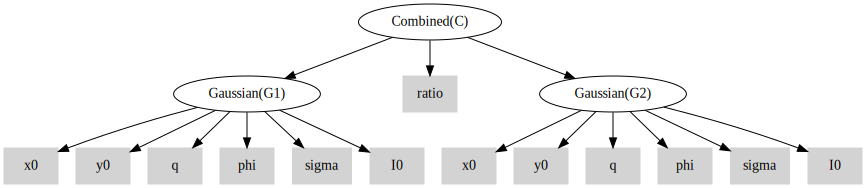

Individual params can be set to dynamic


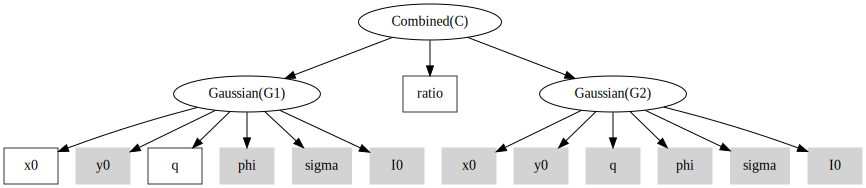

All params for the entire simulator may be set to dynamic


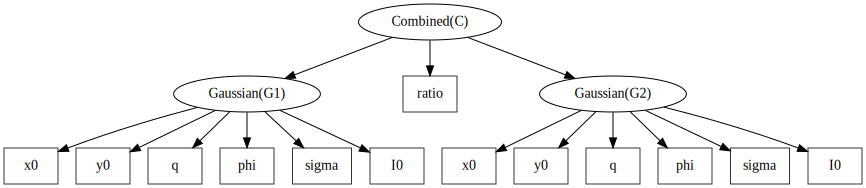

x0: tensor(5)
Individual params can be set to static


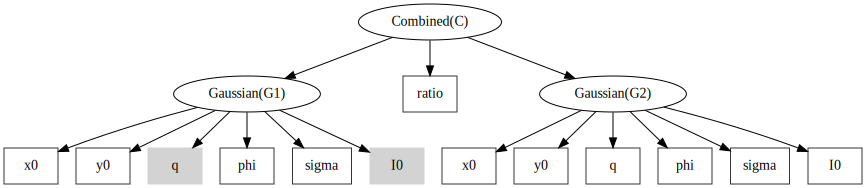

All params for the entire simulator may be set to static


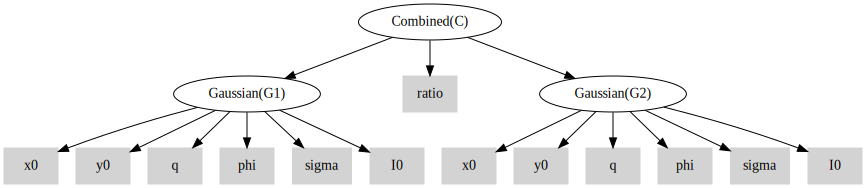

Use a NodeList to curate which params are set to dynamic/static


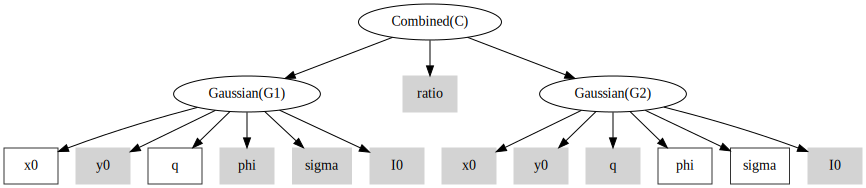

Blank param is dynamic:  True
Caught error: <class 'caskade.errors.ParamTypeError'>: Cannot set dynamic parameter badparam to static when no `dynamic_value` is set. Try using `static_value(value)` to provide a value and set to static.
Param is still dynamic:  True


In [4]:
# All params initialized with a value
G1 = Gaussian("G1", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
G2 = Gaussian("G2", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
C = Combined("C", G1, G2)
print("All params are static automatically when given a value")
display(C.graphviz())

# Set individual param to dynamic
G1.x0.to_dynamic()  # call function to set dynamic
G1.q = None  # set to None to make fully dynamic
G1.q.dynamic_value(0.5)  # set with dynamic value
C.to_dynamic()  # only sets immediate children to dynamic
print("Individual params can be set to dynamic")
display(C.graphviz())

# Set all simulator params to be dynamic
C.to_dynamic(children_only=False)
print("All params for the entire simulator may be set to dynamic")
display(C.graphviz())

# Even when set to dynamic, the params remember their original values
print("x0:", G1.x0.value)
G1.x0 = G1.x0.value  # Setting value sets to static
G1.q.to_static()  # Setting to static, uses the earlier value

# Setting a value and make it static
G1.I0.static_value(10.0)
print("Individual params can be set to static")
display(C.graphviz())

# Similarly a whole simulator can be set static
C.to_static(children_only=False)
print("All params for the entire simulator may be set to static")
display(C.graphviz())

# Use a param list to set multiple params to dynamic
paramset1 = ck.NodeList([G1.x0, G1.q, G2.phi, G2.sigma])
paramset1.to_dynamic()  # set all params in the list to dynamic
print("Use a NodeList to curate which params are set to dynamic/static")
display(C.graphviz())

# NOTE: trying to set a dynamic param to static when there is no stored value will throw an error
badparam = ck.Param("badparam")
print("Blank param is dynamic: ", badparam.dynamic)
try:
    badparam.to_static()
except Exception as e:
    print(f"Caught error: {type(e)}: {e}")
    print("Param is still dynamic: ", badparam.dynamic)

## Call function with internally modified param value

A caskade simulator often is build of nested modules that call each others functions. Sometimes one may wish to call a function but with a different value for one of the Params than what has been given in the input (for example when computing a reference for comparison). Here we will show how to do this kind of local Param modification. This is also covered in [Ways of accessing Param values](#ways-of-accessing-param-values).

In [5]:
class TryModify(ck.Module):
    def __init__(self, submod):
        super().__init__()
        self.submod = submod
        self.newval1 = torch.tensor(2.0)
        self.newval2 = torch.tensor(3.0)

    @ck.forward
    def test_modify(self):
        init = self.submod.brightness(0, 0)  # call with original param values
        mod = self.submod.brightness(0, 0, sigma=self.newval1)  # call with modified param value
        with ck.OverrideParam(self.submod.sigma, self.newval2):
            othermod = self.submod.brightness(0, 0)  # call with temporarily modified param value
        assert init != mod
        assert init != othermod
        assert mod != othermod
        print("See, they are all different!")
        return init, mod, othermod


G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
T = TryModify(G)
print(T.test_modify())

See, they are all different!
(tensor(2.6810e-14), tensor(0.0004), tensor(0.0310))


## Reparametrize a Module

Sometimes it makes sense to write a module and its functions using a particular parametrization, but on some occasions or for user interpretation it should be given in another parametrization. For example, it may be easier to write some model in cartesian coordinates, but for users the polar coordinates are easier to interpret. 

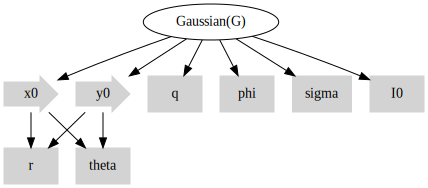

In [6]:
G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)  # default in cartesian coordinates
r = ck.Param("r", 1.0)  # radius
theta = ck.Param("theta", 0.0)  # angle
G.x0 = lambda p: p.r.value * torch.cos(p.theta.value)
G.x0.link([r, theta])
G.y0 = lambda p: p.r.value * torch.sin(p.theta.value)
G.y0.link([r, theta])

G.graphviz()

## Save, Append, and Load the Param values

It is possible to save the state of the params in a `caskade` simulator in an HDF5 file. Once saved, one can append to the file to create a "chain" such as in MCMC sampling.

Note: it is also possible to store other data in the hdf5 file. Simply add the relevant attribute to the `saveattr` set of any of the `caskade` nodes and it will be stored at the appropriate place in the graph. This would be redundant, but for example you could do `Node.saveattr.add('name')` and the `Node.name` will get stored in the HDF5 file. The `Node.name` attribute would also then get overwritten if you load the state (though in this case it would overwrite to the same value).

In [7]:
# Recreate the gaussian in polar coordinates example
G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
G.test_save = torch.tensor([1.0, 2.0, 3.0])
G.saveattrs.add("test_save")
r = ck.Param("r", 1.0)
theta = ck.Param("theta", 0.0)
G.x0 = lambda p: p.r.value * torch.cos(p.theta.value)
G.x0.link([r, theta])
G.y0 = lambda p: p.r.value * torch.sin(p.theta.value)
G.y0.link([r, theta])

# Run the "MCMC"
G.save_state("gauss_chain.h5", appendable=True)  # save the initial state

# Pretend to run a sampling chain
for _ in range(100):
    G.x0.value += np.random.normal(0.01, 0.1)
    G.y0.value += np.random.normal(0.01, 0.1)
    G.q.value = np.clip(G.q.value + 0.1 * np.random.randn(), 0.1, 0.9)
    G.phi.value = (G.phi.value + 0.1 * np.random.randn()) % np.pi
    G.sigma.value += np.random.normal(0.1, 0.05)
    G.I0.value += np.random.normal(0.01, 0.5)

    G.append_state("gauss_chain.h5")  # append the new state

Check value of test_save:  [1. 2. 3.]


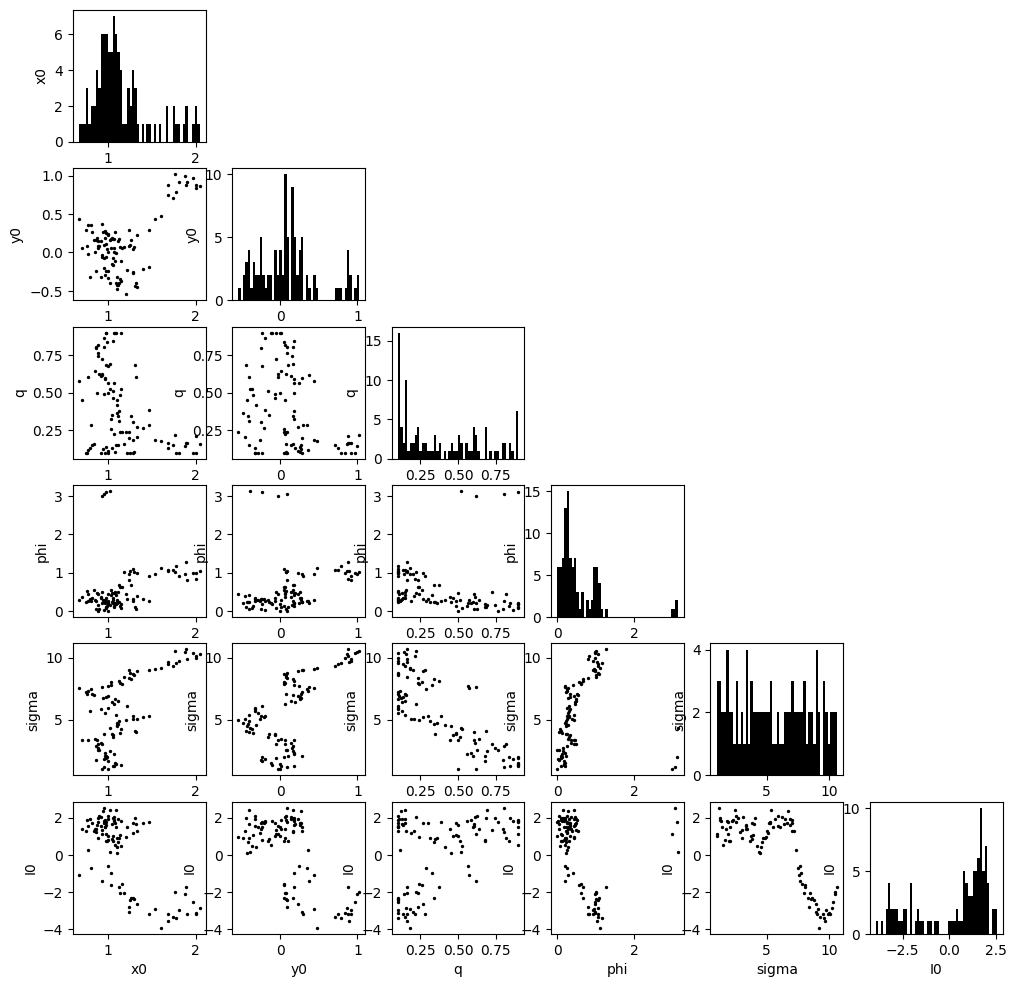

In [8]:
# Now we can read the chain back in
fig, axarr = plt.subplots(6, 6, figsize=(12, 12))
with h5py.File("gauss_chain.h5", "r") as f:  # Load the hdf5 file directly
    print("Check value of test_save: ", f["G"].attrs["test_save"])  # access saved attributes
    for i, ikey in enumerate(["x0", "y0", "q", "phi", "sigma", "I0"]):
        idata = f["G"][ikey]["value"]  # access values for a given param
        for j, jkey in enumerate(["x0", "y0", "q", "phi", "sigma", "I0"]):
            jdata = f["G"][jkey]["value"]  # access values for a given param
            if i < j:
                axarr[i, j].axis("off")
                continue
            elif i == j:
                axarr[i, j].hist(idata, bins=50, color="k")
                axarr[i, j].set_xlabel(ikey)
                axarr[i, j].set_ylabel("Counts")
            else:
                axarr[i, j].scatter(jdata, idata, s=2, color="k")
            axarr[i, j].set_xlabel(jkey)
            axarr[i, j].set_ylabel(ikey)
plt.show()

You can also simply load the state of a module from the hdf5 file.

In [9]:
G.load_state("gauss_chain.h5", 32)  # Load the 32nd state from the chain

print("Loaded state 32:")
print(f"x0: {G.x0.value.item():.2f}")
print(f"y0: {G.y0.value.item():.2f}")
print(f"q: {G.q.value.item():.2f}")
print(f"phi: {G.phi.value.item():.2f}")
print(f"sigma: {G.sigma.value.item():.2f}")
print(f"I0: {G.I0.value.item():.2f}")

Loaded state 32:
x0: 1.89
y0: 0.88
q: 0.49
phi: 0.27
sigma: 3.82
I0: 1.69


## Add meta data to a Param or Module

Sometimes it is very useful to carry along some extra data right next to your params. For example, you may want to keep track of the uncertainty of a param value. Since params and modules are objects, you can add attributes how you like! Just don't override an existing attribute or you might cause chaos.

In [10]:
p = ck.Param("p", 1.0)

p.extra_info = 42

It is also possible to define new types of `Param` objects by subclassing `Param`, however one should be careful not to make differences too extreme if they wish to interact with other `caskade` based packages. A straightforward example would be when making a package where every parameter will store an uncertainty, rather than creating the attribute for each new `Param`, one can just make a class that starts with it from the outset.

In [11]:
class ParamU(ck.Param):
    def __init__(self, *args, uncertainty=None, **kwargs):
        super().__init__(*args, **kwargs)
        if uncertainty is None:
            self.uncertainty = torch.zeros_like(self.value)
        else:
            self.uncertainty = uncertainty


p = ParamU("p", 1.0)
print(f"p: {p.value} +- {p.uncertainty}")
p2 = ParamU("p2", 2.0, uncertainty=0.1)
print(f"p2: {p2.value} +- {p2.uncertainty}")

p: 1.0 +- 0.0
p2: 2.0 +- 0.1


## Break up a Param Tensor

Sometimes a `Param` value is naturally a multi-component tensor, but we only wish for part of it to be dynamic. This can be accomplished by creating new params and linking appropriately.

Original x tensor tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Rebuilt x tensor tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


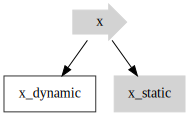

In [12]:
# This is the param we plan to use
x = ck.Param("x", torch.arange(10))  # param has 10 elements
print("Original x tensor", x.value)

# These are sub params for the broken primary param
x_dynamic = ck.Param("x_dynamic", torch.arange(3))  # want first three elements to be dynamic
x_dynamic.to_dynamic()
x_static = ck.Param("x_static", torch.arange(3, 10))  # want last seven elements to be static

# This rebuilds the full param from the broken params
x.value = lambda p: torch.cat((p.x_dynamic.value, p.x_static.value))
x.link(x_dynamic)
x.link(x_static)

# Here we see we get the same result, but now only the first three elements are dynamic!
print("Rebuilt x tensor", x.value)
x.graphviz()

## Batching with caskade

Adding batch dimensions allows for more efficient computation by requiring less communication between the CPU and GPU, or simply by letting the CPU spend more time doing computations and less time reading python code. In `caskade` it is possible to fully take advantage of batching capabilities of ones code. Here we demo the basic format for doing so.

### Case 1, vmap

`vmap` is a utility in PyTorch that lets you automatically add a batch dimension to your inputs and outputs. You can think of it like a faster version of a `for-loop` that just stacks all the outputs together.

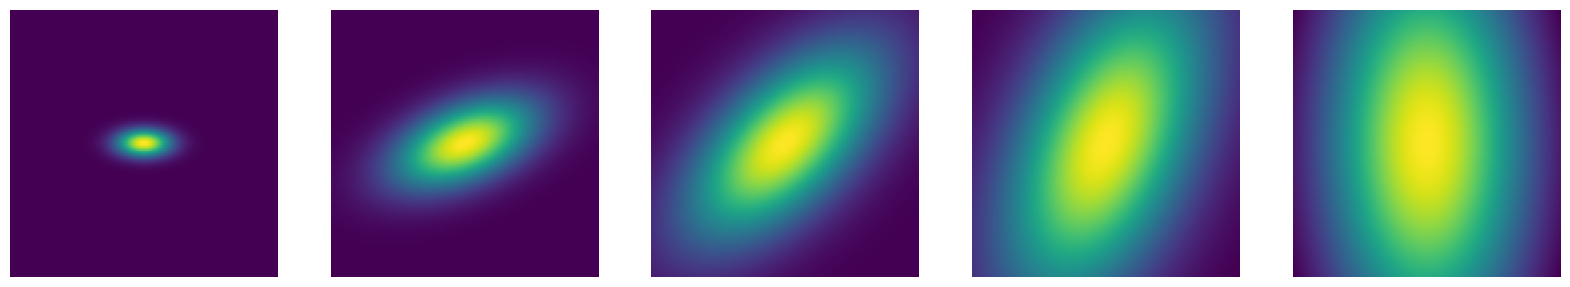

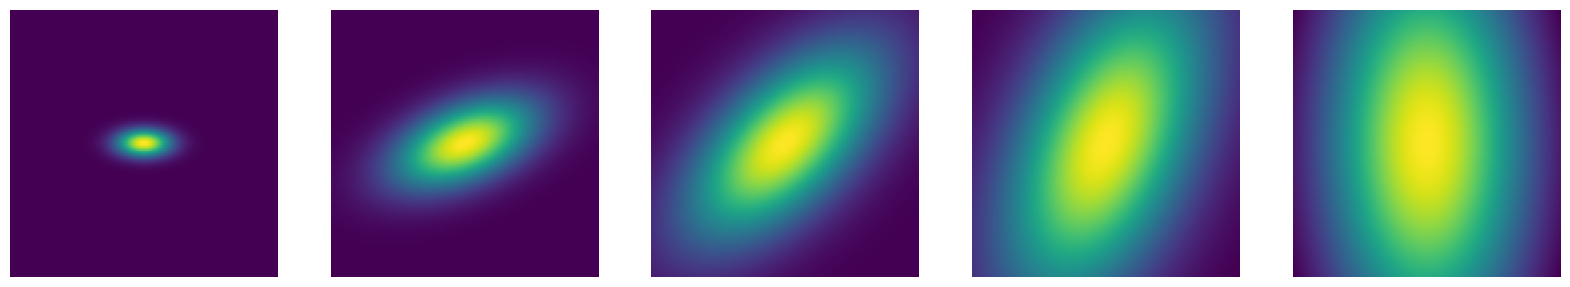

In [13]:
G = Gaussian("G", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
G.sigma.to_dynamic()
G.phi.to_dynamic()
x, y = torch.meshgrid(torch.linspace(0, 10, 100), torch.linspace(0, 10, 100), indexing="ij")

# Batching using vmap                phi                            sigma
params = torch.stack((torch.linspace(0.0, 3.14 / 2, 5), torch.linspace(0.5, 4.0, 5)), dim=-1)
img = torch.vmap(G.brightness, in_dims=(None, None, 0), out_dims=0)(x, y, params)
fig, axarr = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axarr):
    ax.imshow(img[i].detach().numpy(), origin="lower")
    ax.axis("off")
plt.show()

# Multiple batching with vmap
# imagine the brightness function could only take a single value, rather than a grid
#                                            batch x y                        batch params
img = torch.vmap(torch.vmap(G.brightness, in_dims=(0, 0, None)), in_dims=(None, None, 0))(
    x.flatten(), y.flatten(), params
)
img = img.reshape(5, *x.shape)
fig, axarr = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axarr):
    ax.imshow(img[i].detach().numpy(), origin="lower")
    ax.axis("off")
plt.show()

### Case 2, Module with batch dimension

If you write a module assuming the user will pass parameters with a batch dimension, then you can handle direct batching without using wrappers like `vmap`. This requires a bit more care in managing the shapes of each object, but can pay off a lot in terms of speed and flexibility later on!

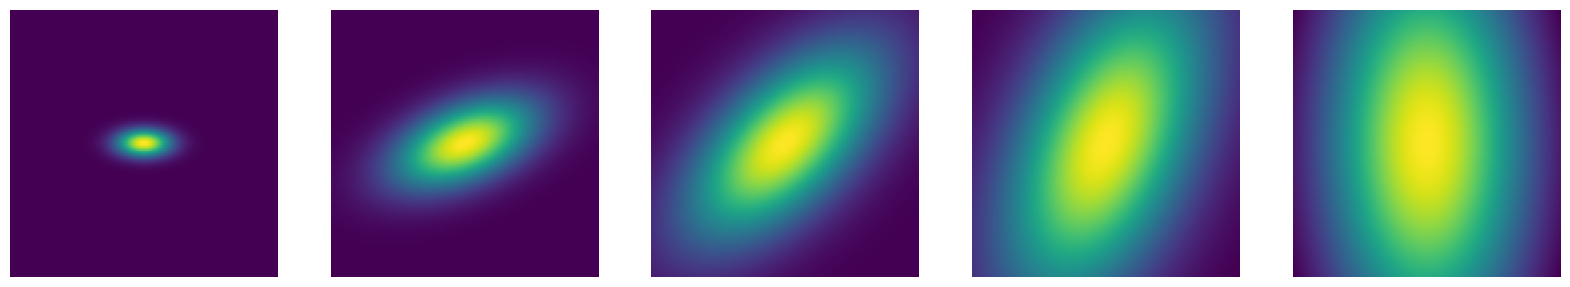

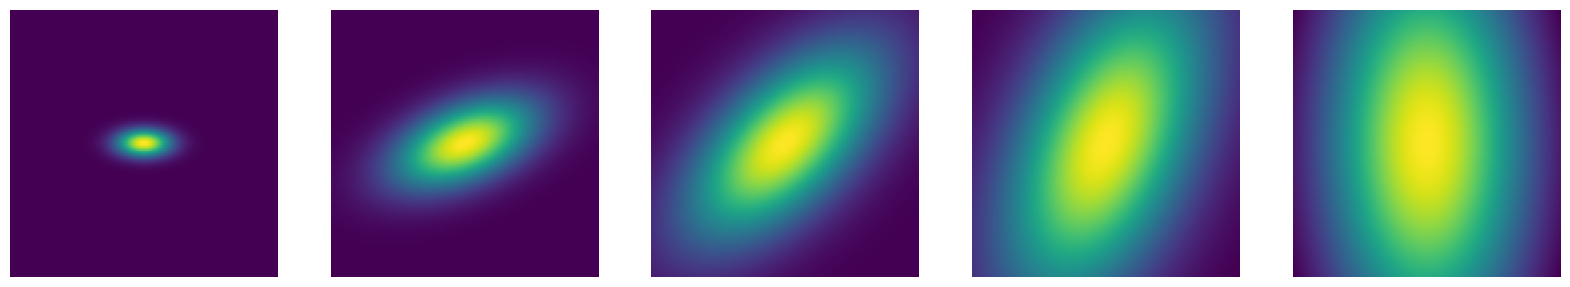

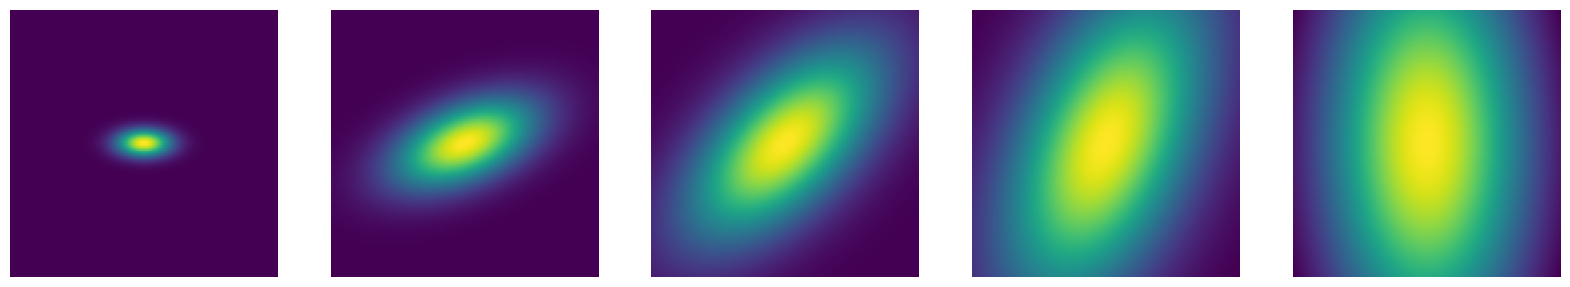

In [14]:
class GaussianBatched(ck.Module):
    def __init__(self, name, x0=None, y0=None, q=None, phi=None, sigma=None, I0=None):
        super().__init__(name)
        self.x0 = ck.Param("x0", x0)  # position
        self.y0 = ck.Param("y0", y0)
        self.q = ck.Param("q", q)  # axis ratio
        self.phi = ck.Param("phi", phi)  # orientation
        self.sigma = ck.Param("sigma", sigma)  # width
        self.I0 = ck.Param("I0", I0)  # intensity

    @ck.forward
    def _r(self, x, y, x0=None, y0=None, q=None, phi=None):
        x0 = x0.unsqueeze(-1)
        y0 = y0.unsqueeze(-1)
        q = q.unsqueeze(-1)
        phi = phi.unsqueeze(-1)
        x, y = x - x0, y - y0
        s, c = torch.sin(phi), torch.cos(phi)
        x, y = c * x - s * y, s * x + c * y
        return (x**2 + (y * q) ** 2).sqrt()

    @ck.forward
    def brightness(self, x, y, sigma=None, I0=None):
        init_shape = x.shape
        B, *_ = sigma.shape
        x = x.flatten()
        y = y.flatten()
        return (I0.unsqueeze(-1) * (-self._r(x, y) ** 2 / sigma.unsqueeze(-1) ** 2).exp()).reshape(
            B, *init_shape
        )


G = GaussianBatched("G", x0=[5], y0=[5], q=[0.5], phi=[0.0], sigma=[1.0], I0=[1.0])
G.to_dynamic()  # all params are dynamic
x, y = torch.meshgrid(torch.linspace(0, 10, 100), torch.linspace(0, 10, 100), indexing="ij")

# Batching on all dims using batched tensor input
params = G.build_params_array()
params = params.repeat(5, 1)  # 5 copies of the same params
params[:, 3] = torch.linspace(0.0, 3.14 / 2, 5)  # phi
params[:, 4] = torch.linspace(0.5, 4.0, 5)  # sigma
img = G.brightness(x, y, params=params)
fig, axarr = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axarr):
    ax.imshow(img[i].detach().numpy(), origin="lower")
    ax.axis("off")
plt.show()

# Batching by setting shapes of params, then flat tensor input
for param in G.dynamic_params:
    param.value = None
    param.shape = (5,) + param.shape  # add batch dimension to shape
params = params.T.flatten()  # now params is a flat tensor again
img = G.brightness(x, y, params=params)
fig, axarr = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axarr):
    ax.imshow(img[i].detach().numpy(), origin="lower")
    ax.axis("off")
plt.show()

# Batching using list input, note that list allows for different shapes, (also true for dictionary params)
params = [
    torch.tensor(5),  # x0
    torch.tensor(5),  # y0
    torch.tensor(0.5),  # q
    torch.linspace(0.0, 3.14 / 2, 5),  # phi, batched
    torch.linspace(0.5, 4.0, 5),  # sigma, batched
    torch.tensor(1.0),  # I0
]
img = G.brightness(x, y, params=params)
fig, axarr = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axarr):
    ax.imshow(img[i].detach().numpy(), origin="lower")
    ax.axis("off")
plt.show()

## Remove Param from a Module

It is possible to remove a Param object from a module and later replace it. This may be helpful for getting a simulator exactly the way you want it. You may use this to have multiple modules share a Param rather than just pointing to the same object. Generally, this is not preferred practice since it is just as fast to use pointers and they are more flexible.

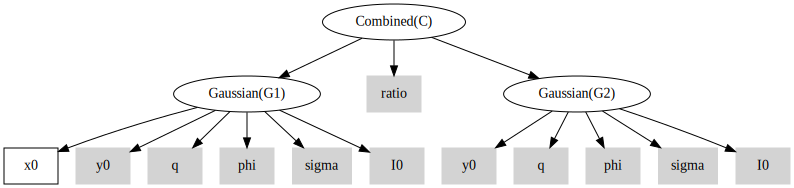

In [15]:
G1 = Gaussian("G1", x0=None, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
G2 = Gaussian("G2", x0=5, y0=5, q=0.5, phi=0.0, sigma=1.0, I0=1.0)
C = Combined("C", G1, G2)

del G2.x0  # remove a param from a module

C.graphviz()

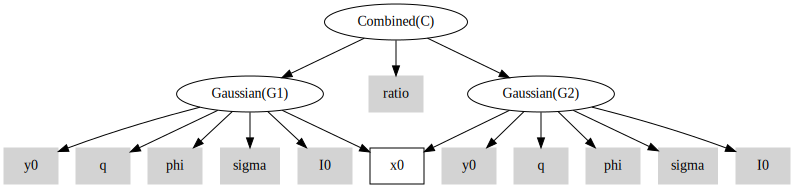

In [16]:
G2.x0 = G1.x0  # assign a param from one module to another
C.graphviz()

## Pointer functions only called once

When you create a pointer function it may be arbitrarily complex, which may require a lot of compute. To maintain efficiency, the pointer is only called once for a given simulation then the value is stored. This shouldn't matter on the user side, but it is just good to know!

In [17]:
class TryCallPointer(ck.Module):
    def __init__(self):
        super().__init__()
        self.x = ck.Param("x", 1.0)
        self.y = ck.Param("y", 2.0)

    @ck.forward
    def test_call(self):
        total = 0.0
        start = time()
        total += self.x.value
        print(f"first call took {time()-start:.5f} sec")
        start = time()
        total += self.x.value
        print(f"second call took {time()-start:.5f} sec")
        return total


def long_function(p):
    sleep(2)
    return 1.0 + p.y.value


T = TryCallPointer()
T.x = long_function
T.x.link(T.y)
print(T.test_call())

print("\nOutside @forward the pointer is called every time:")
start = time()
T.x.value
print(f"first outside call took {time()-start:.5f} sec")
start = time()
T.x.value
print(f"second outside call took {time()-start:.5f} sec")

first call took 2.00024 sec
second call took 0.00025 sec
tensor(6.)

Outside @forward the pointer is called every time:
first outside call took 2.00075 sec
second outside call took 2.00082 sec
